# Experimentation and Uplift Testing
- Trial stores were performed in stores 77, 86 and 88. 
- Trial period starts on February 2019 until April 2019.

For this task we want to do the following:
- determine which control store is comparable to each trial store
- analyze and perform hypothesis testing to determine if the difference of each store between its pre-trial and trial period is statistically significant

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

pd.options.mode.chained_assignment = None  

In [2]:
#cleaned transaction_data merged with customer_data
data = pd.read_csv('QVI_data.csv', parse_dates=['DATE']) 

## I. Data processing
Prepare all needed measures and tables for analysis

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   LYLTY_CARD_NBR    264834 non-null  int64         
 1   DATE              264834 non-null  datetime64[ns]
 2   STORE_NBR         264834 non-null  int64         
 3   TXN_ID            264834 non-null  int64         
 4   PROD_NBR          264834 non-null  int64         
 5   PROD_NAME         264834 non-null  object        
 6   PROD_QTY          264834 non-null  int64         
 7   TOT_SALES         264834 non-null  float64       
 8   PACK_SIZE         264834 non-null  int64         
 9   BRAND             264834 non-null  object        
 10  LIFESTAGE         264834 non-null  object        
 11  PREMIUM_CUSTOMER  264834 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(6), object(4)
memory usage: 24.2+ MB


In [4]:
data.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


We need to define the measures for our stores. We calculate these measures for the following:
- total sales of chips
- number of customers
- average number of transactions per customer
- avergae number of chips bought per customer
- average price per unit of chips

In [5]:
def calculate_measures(data) -> pd.DataFrame:
    """
    Function to calculate for measures of each store per month.
    This will return a DataFrame with the needed measurements.
    """
    
    data['YEARMONTH'] = data.DATE.dt.strftime("%Y%m").astype(int)
    
    measures = data.groupby(['STORE_NBR','YEARMONTH'])\
                   .agg({"TXN_ID":"count",
                         "TOT_SALES":"sum",
                         "PROD_QTY":"sum",
                         "LYLTY_CARD_NBR":"nunique"})\
                   .reset_index()\
                   .rename(columns={"TXN_ID":"TXN_COUNT",
                                    "LYLTY_CARD_NBR":"CUST_COUNT"})
                                                                        
    measures['TXN_PER_CUST'] = measures.TXN_COUNT/measures.CUST_COUNT
    measures['CHPS_PER_CUST'] = measures.PROD_QTY/measures.CUST_COUNT
    measures['PRICE_PER_UNIT'] = measures.TOT_SALES/measures.PROD_QTY
    
    return measures

There are 3 trials which began in Feb 2019 until Apr 2019. In order to compare with a control group, we would need to have a control group with the following criteria:
- stores with a complete set of months (complete data for all 12 months)
- stores with pre-trial measures, such as correlation and magnitude distance, having the closest similarity to our trial stores

In [6]:
def correlation(t_store_nbr, c_store_nbr, columns, measures) -> pd.DataFrame:
    """
    Function to calculate for the correlation of each control store
    to the given trial store
    """
    
    corr_dict = {"YEARMONTH": [],
                 "TRIAL_STORE_NBR": [],
                 "CONTROL_STORE_NBR": [],
                 "CORR_SCORE": []}

    for i in c_store_lst:

        trial_store = measures[measures.STORE_NBR==t_store_nbr]
        control_store = measures[measures.STORE_NBR==i]

        corr_dict["YEARMONTH"].extend(trial_store['YEARMONTH'].to_list())
        corr_dict['TRIAL_STORE_NBR'].extend(trial_store['STORE_NBR'].to_list())
        corr_dict['CONTROL_STORE_NBR'].extend(control_store['STORE_NBR'].to_list())
        corr_dict["CORR_SCORE"].extend(trial_store[columns].reset_index()\
                               .corrwith(control_store[columns].reset_index(),
                                axis=1,method='pearson',drop=True).to_list())
        
    return pd.DataFrame(corr_dict)

We can also calculate the magnitude distance for each measure

In [7]:
def magnitude_distance(t_store_nbr, c_store_nbr, columns, measures) -> pd.DataFrame:
    """
    Function to calculate for the magnitude distance. This
    will return standardized distances for each column.
    """    
    
    df1 = measures[measures.STORE_NBR==t_store_nbr][columns].reset_index(drop=True)
    
    distance = []
    for i in c_store_nbr:
        
        control = measures[measures.STORE_NBR==i]
        df2 = control[columns].reset_index(drop=True)
        diff = abs(df1.subtract(df2))

        diff['CONTROL_STORE_NBR'] = i
        diff['YEARMONTH'] = control['YEARMONTH'].to_list()

        distance.append(diff)
        
    final = pd.concat(distance)
    final['TRIAL_STORE_NBR'] = t_store_nbr

    for col in columns:
        final[col] = 1 - ((final[col]-final[col].min())/(final[col].max()-final[col].min()))
    
    #we average the magnitude distance for each store and month
    final['MAG_SCORE'] = final[columns].mean(axis=1)

    return final[['YEARMONTH','TRIAL_STORE_NBR','CONTROL_STORE_NBR','MAG_SCORE']]

To rank the stores, we can take the average of our correlation and distance measurements for each store.

In [8]:
def combined_measures(t_store_nbr, c_store_nbr, columns, measures, corr_weight=0.5):
    """
    This function will call both correlation() and magnitude_distance()
    to average their measures for a final control score
    """
    
    indices = ['YEARMONTH','TRIAL_STORE_NBR','CONTROL_STORE_NBR']
    
    corr_measure = correlation(t_store_nbr, c_store_nbr, columns, measures)
    mag_measure = magnitude_distance(t_store_nbr, c_store_nbr, columns, measures)
    
    mag_weight = 1 - corr_weight
    
    combined = corr_measure.merge(mag_measure, on=indices)
    combined['CONTROL_SCORE'] = (combined.CORR_SCORE*corr_weight) + (combined.MAG_SCORE*mag_weight)
    
    return combined.groupby(['TRIAL_STORE_NBR','CONTROL_STORE_NBR']).mean().reset_index()

In [9]:
measures = calculate_measures(data)
pre_trial_measures = measures[measures.YEARMONTH < 201902]
trial_measures = measures[(measures.YEARMONTH >= 201902)&(measures.YEARMONTH <= 201904)]

c_store_lst = measures.groupby('STORE_NBR')['YEARMONTH'].count().reset_index()
c_store_lst = c_store_lst[c_store_lst.YEARMONTH == 12]['STORE_NBR'].to_list()

In [10]:
columns = ['TOT_SALES']
print(f"For columns: {columns}")
print("Top 3 control stores for each trial store within the pre-trial period:","\n")
for t in [77,86,88]:
    combined = combined_measures(t, c_store_lst, columns, pre_trial_measures)
    top_3 = combined[~combined.CONTROL_STORE_NBR.isin([77,86,88])]\
                              .sort_values('CONTROL_SCORE',
                                           ascending=False)\
                                           [['CONTROL_STORE_NBR','CONTROL_SCORE']]\
                              .drop_duplicates('CONTROL_STORE_NBR')\
                              .reset_index(drop=True).head(3)
    print(f"Trial store {t}:\n{top_3}","\n")

For columns: ['TOT_SALES']
Top 3 control stores for each trial store within the pre-trial period: 

Trial store 77:
   CONTROL_STORE_NBR  CONTROL_SCORE
0                233       0.993238
1                255       0.989739
2                188       0.988831 

Trial store 86:
   CONTROL_STORE_NBR  CONTROL_SCORE
0                109       0.983289
1                155       0.982836
2                222       0.981038 

Trial store 88:
   CONTROL_STORE_NBR  CONTROL_SCORE
0                 40       0.970582
1                 26       0.952189
2                 72       0.951900 



In [11]:
columns=['CUST_COUNT']
print(f"For columns: {columns}")
print("Top 3 control stores for each trial store within the pre-trial period:","\n")
for t in [77,86,88]:
    combined = combined_measures(t, c_store_lst, columns, pre_trial_measures)
    top_3 = combined[~combined.CONTROL_STORE_NBR.isin([77,86,88])]\
                              .sort_values('CONTROL_SCORE',
                                           ascending=False)\
                                           [['CONTROL_STORE_NBR','CONTROL_SCORE']]\
                              .drop_duplicates('CONTROL_STORE_NBR')\
                              .reset_index(drop=True).head(3)
    print(f"Trial store {t}:\n{top_3}","\n")

For columns: ['CUST_COUNT']
Top 3 control stores for each trial store within the pre-trial period: 

Trial store 77:
   CONTROL_STORE_NBR  CONTROL_SCORE
0                233       0.996566
1                 41       0.988324
2                111       0.984203 

Trial store 86:
   CONTROL_STORE_NBR  CONTROL_SCORE
0                155       0.993386
1                225       0.984788
2                109       0.984788 

Trial store 88:
   CONTROL_STORE_NBR  CONTROL_SCORE
0                237       0.993909
1                203       0.972315
2                 40       0.971207 



## II. Analyzing data for trial and control measures
Pre-trial months occur before April 2019. We will gather measures for each store similarly to our previous task with customer segmentation.

In [12]:
measures.head()

,STORE_NBR,YEARMONTH,TXN_COUNT,TOT_SALES,PROD_QTY,CUST_COUNT,TXN_PER_CUST,CHPS_PER_CUST,PRICE_PER_UNIT
0,1,201807,52,206.9,62,49,1.061224,1.265306,3.337097
1,1,201808,43,176.1,54,42,1.023810,1.285714,3.261111
2,1,201809,62,278.8,75,59,1.050847,1.271186,3.717333
3,1,201810,45,188.1,58,44,1.022727,1.318182,3.243103
4,1,201811,47,192.6,57,46,1.021739,1.239130,3.378947


### Total sales per month
We analyze the sales per month of our trial store and control stores.

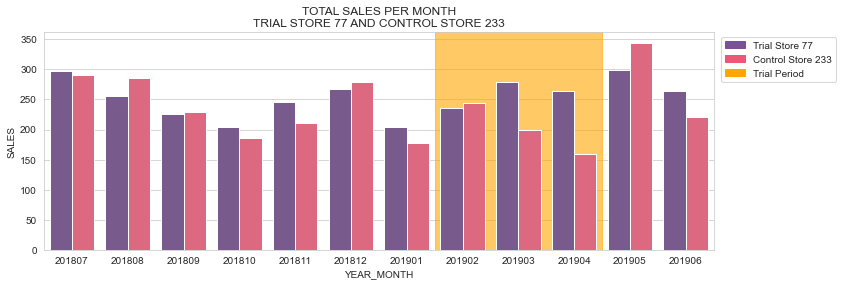

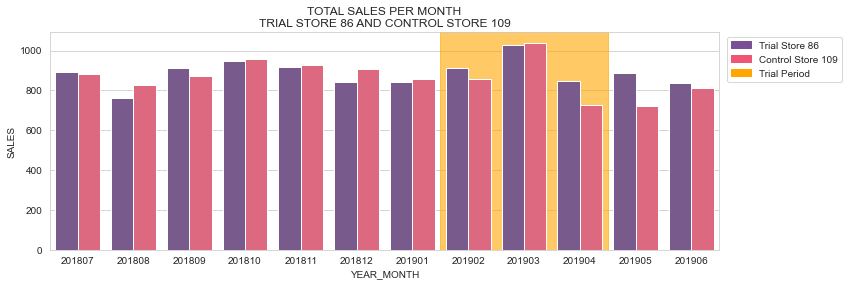

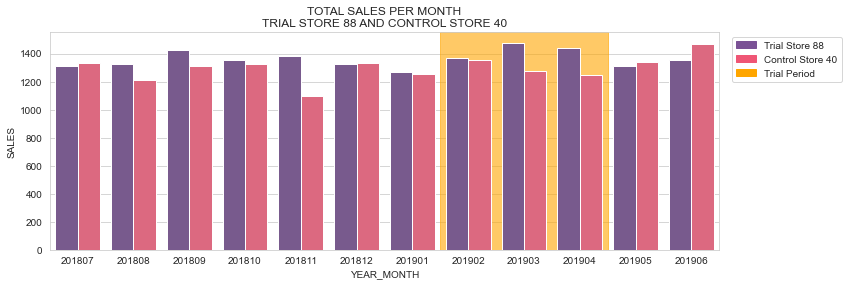

In [13]:
sns.set_style("whitegrid")
colorList = ['#7a5195','#ef5675','#ffa600']
trials, controls = [77,86,88], [233,109,40]

for trial, control in zip(trials, controls):
    labelList = [f"Trial Store {trial}",f"Control Store {control}",'Trial Period']
    handles = [mpatches.Patch(color=color, label=label)\
               for color, label in zip(colorList,labelList)]

    data_c =  measures[measures.STORE_NBR.isin([trial,control])]

    plt.figure(figsize=(12,4))
    plt.axvspan(6.5,9.5,
                color='#ffa600',
                alpha=0.6)
    sns.barplot(data=data_c, 
                x='YEARMONTH', 
                y='TOT_SALES', 
                hue='STORE_NBR',
                hue_order=[trial,control],
                palette=colorList)
    plt.title(f'TOTAL SALES PER MONTH\nTRIAL STORE {trial} AND CONTROL STORE {control}')
    plt.xlabel('YEAR_MONTH')
    plt.ylabel('SALES')
    plt.legend(handles=handles,
               loc="upper right",
               bbox_to_anchor=(1.19,1))
    
    plt.savefig(f"results_images/task2_totsales_t{trial}c{control}.png", bbox_inches='tight', dpi=300)
    plt.show()

### Number of customers per month

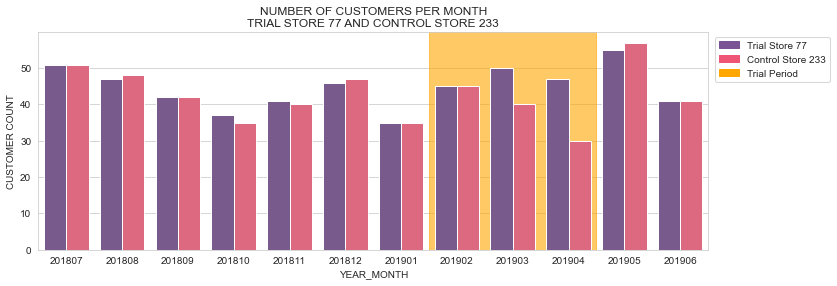

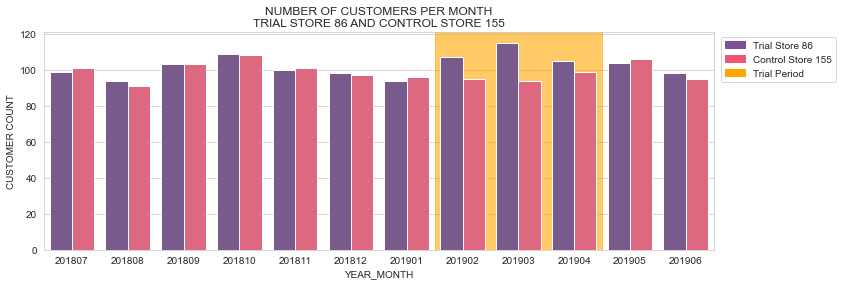

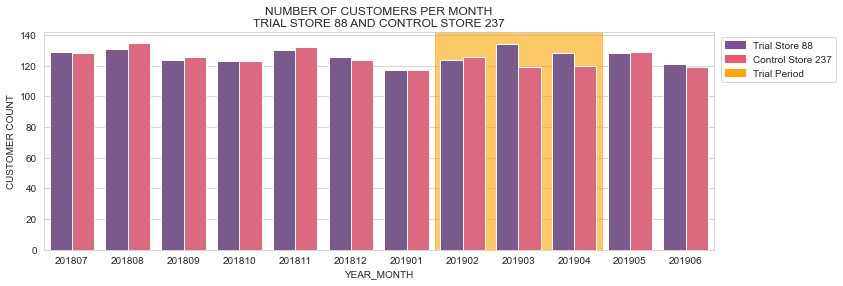

In [14]:
controls = [233,155,237]

for trial, control in zip(trials, controls):
    labelList = [f"Trial Store {trial}",f"Control Store {control}",'Trial Period']
    handles = [mpatches.Patch(color=color, label=label)\
               for color, label in zip(colorList,labelList)]

    data_c =  measures[measures.STORE_NBR.isin([trial,control])]

    plt.figure(figsize=(12,4))
    plt.axvspan(6.5,9.5,
                color='#ffa600',
                alpha=0.6)
    sns.barplot(data=data_c, 
                x='YEARMONTH', 
                y='CUST_COUNT', 
                hue='STORE_NBR',
                hue_order=[trial,control],
                palette=colorList)
    plt.title(f'NUMBER OF CUSTOMERS PER MONTH\nTRIAL STORE {trial} AND CONTROL STORE {control}')
    plt.xlabel('YEAR_MONTH')
    plt.ylabel('CUSTOMER COUNT')
    plt.legend(handles=handles,
               loc="upper right",
               bbox_to_anchor=(1.19,1))
    
    plt.savefig(f"results_images/task2_custcount_t{trial}c{control}.png", bbox_inches='tight', dpi=300)
    plt.show()

### Scaling pre-trial sales and customer count
We would want to find if there has been an uplift during the trial period for the overall chip sales and customer count. In order to do this, we need to scale the control store's measure to a level similar to that of the trial store during the pre-trial period.

In [15]:
def scaled_measures(trials, controls, measures, column):
    """
    Scale the control column to a level similar to the trial store
    """
    
    scaled_measures = measures[measures.STORE_NBR.isin(controls)]\
                                       .rename(columns={'STORE_NBR':'CONTROL_STORE_NBR'})\
                                       .reset_index(drop=True)\
                                       .sort_values(['CONTROL_STORE_NBR','YEARMONTH'], ascending=False)
    
    scaled_measures[f'SCALED_{column}'] = 0
    for trial, control in zip(trials, controls):
        scaling_factor = pre_trial_measures[pre_trial_measures.STORE_NBR==trial][column].sum() / \
                         pre_trial_measures[pre_trial_measures.STORE_NBR==control][column].sum()
        scales = measures[measures.STORE_NBR==control][column].apply(lambda sale: sale*scaling_factor).to_list()
        scaled_measures.loc[scaled_measures.CONTROL_STORE_NBR==control,f'SCALED_{column}'] = scales

    scaled_measures['TRIAL_STORE_NBR'] = scaled_measures.CONTROL_STORE_NBR.apply(\
                                         lambda row: 77 if row==controls[0] else (86 if row==controls[1] else 88)) 
    trial_sales = measures[measures.STORE_NBR.isin(trials)][['STORE_NBR','YEARMONTH',f'{column}']]\
                                             .rename(columns={'STORE_NBR':'TRIAL_STORE_NBR'})
    scaled_measures = scaled_measures[['TRIAL_STORE_NBR','CONTROL_STORE_NBR','YEARMONTH',f'SCALED_{column}']]\
                                        .merge(trial_sales, on=['TRIAL_STORE_NBR','YEARMONTH'])
    scaled_measures['PERCENT_DIFF'] = abs(scaled_measures[column]-scaled_measures[f'SCALED_{column}'])/\
                                         (scaled_measures[f'SCALED_{column}'])
    return scaled_measures

"-----------------------------------------------------------------------------------------------------------------"

def plot_scaled_measures(trials, controls, measures, column):
    """
    Function which calls the scaled_measures() function and plot the results
    """
    
    scaled_m = scaled_measures(trials, controls, measures, column)

    for trial, control in zip(trials, controls):
        data_c = scaled_m[scaled_m.TRIAL_STORE_NBR==trial]\
                                  .melt(id_vars=['YEARMONTH'], 
                                        value_vars=[column,f'SCALED_{column}'])

        colorList = ['#7a5195','#ef5675','#ffa600']
        labelList = ["Total trial count",'Scaled control count','Trial Period']
        handles = [mpatches.Patch(color=color, label=label)\
                   for color, label in zip(colorList,labelList)]

        plt.figure(figsize=(12,4))
        plt.axvspan(6.5,9.5,
            color='#ffa600',
            alpha=0.6)
        sns.barplot(data=data_c, 
                    x='YEARMONTH', 
                    y='value', 
                    hue='variable',
                    palette=colorList)
        plt.title(f'PRE-TRIAL {column} PER MONTH\nTRIAL STORE {trial} AND CONTROL STORE {control}')
        plt.xlabel('YEAR_MONTH')
        plt.ylabel(f'{column}')
        plt.legend(handles=handles,
                   loc="upper right",
                   bbox_to_anchor=(1.22,1))
        plt.show()

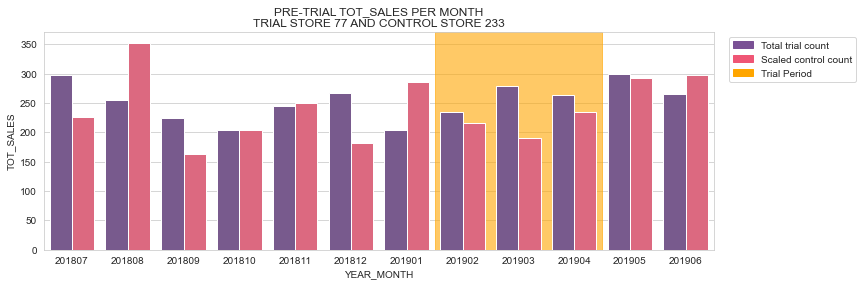

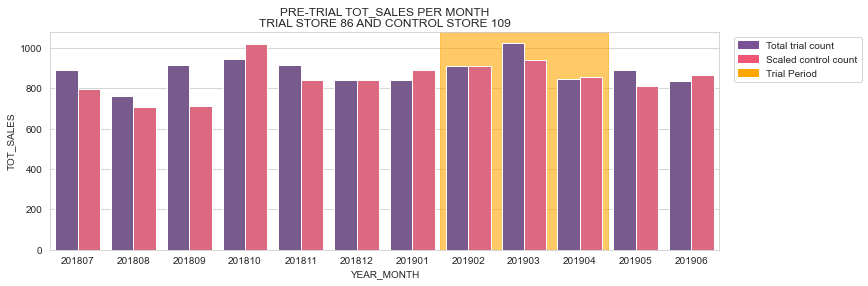

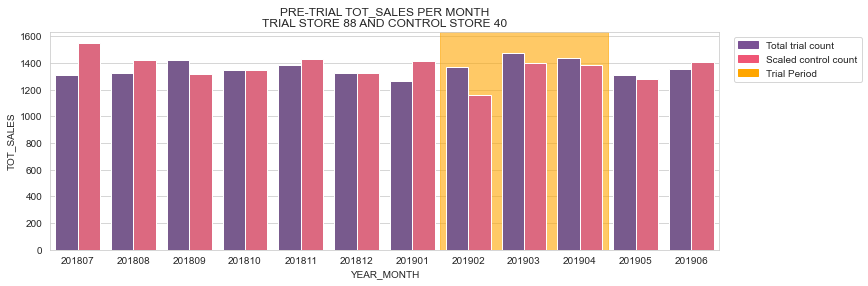

In [16]:
controls, column = [233,109,40], 'TOT_SALES'
plot_scaled_measures(trials, controls, measures, column)

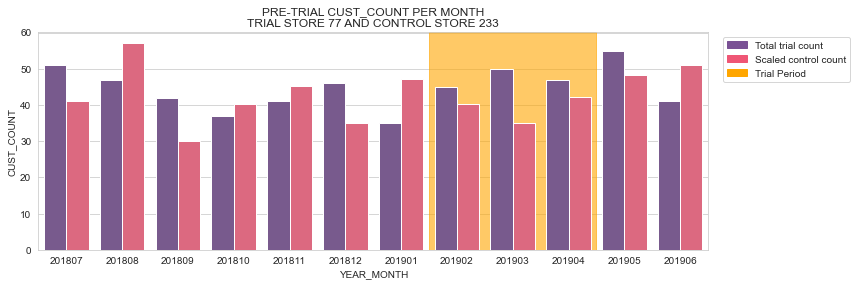

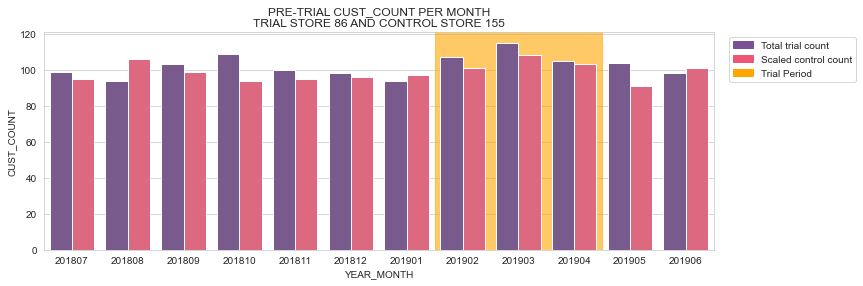

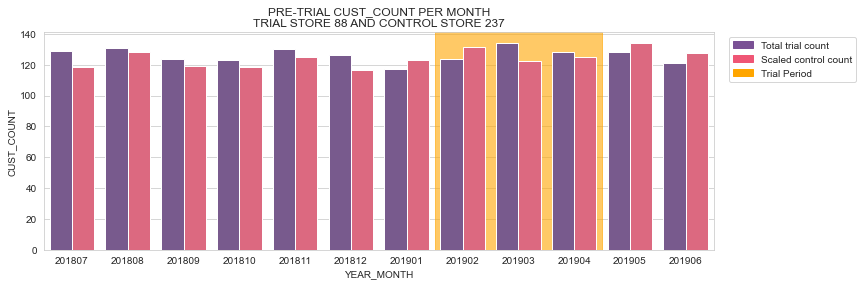

In [17]:
controls, column = [233,155,237], 'CUST_COUNT'
plot_scaled_measures(trials, controls, measures, column)

### Hypothesis testing for control and trial stores
We compare control and trial stores' pre-trial and trial measure and check if there is any significant differences. For our NULL hypothesis, we assume that the trial period is just similar with the pre-trial period. A significance of 5% is set as our alpha value.

In [18]:
from scipy.stats import ttest_ind, t

In [31]:
def hypothesis_test(column, controls, trials=[77,86,88], measures=measures, alpha=0.05):
    
    scaled_m = scaled_measures(trials, controls, measures, column)

    pre_scaled_m = scaled_m[(scaled_m.YEARMONTH < 201902)]
    post_scaled_m = scaled_m[(scaled_m.YEARMONTH >= 201902)\
                         &(scaled_m.YEARMONTH <= 201904)]
    
    #pre-trial vs trial sales for control stores
    print("-----------------------------------------------")
    print("Pre-trial vs Trial sales for CONTROL stores:")
    print("-----------------------------------------------")
    for control in controls:
        t1 = pre_scaled_m[pre_scaled_m.CONTROL_STORE_NBR==control][f'SCALED_{column}']
        t2 = post_scaled_m[post_scaled_m.CONTROL_STORE_NBR==control][f'SCALED_{column}']

        print(f"Pre-trial vs trial sales t-test for CONTROL store {control}:")
        print(ttest_ind(t1,t2,equal_var=False),'\n')
    
    #calculate for the critical t-statistic at 95% confidence interval
    t_stat = t.ppf(q=(alpha/2, 1-alpha/2), df=min(len(t1),len(t2)-1))
    print(f"Critical t-statistic for 95% confidence interval: {t_stat}\n")

    #pre-trial vs trial sales for trial stores
    print("-----------------------------------------------")
    print("Pre-trial vs Trial sales for TRIAL stores:")
    print("-----------------------------------------------")
    for trial in trials:
        t1 = pre_scaled_m[pre_scaled_m.TRIAL_STORE_NBR==trial][column]
        t2 = post_scaled_m[post_scaled_m.TRIAL_STORE_NBR==trial][column]

        print(f"Pre-trial vs trial sales t-test for TRIAL store {trial}:")
        print(ttest_ind(t1,t2,equal_var=False),'\n')
    
    #calculate for the critical t-statistic at 95% confidence interval
    t_stat = t.ppf(q=(alpha/2, 1-alpha/2), df=min(len(t1),len(t2)-1))
    print(f"Critical t-statistic for 95% confidence interval: {t_stat}\n")
    
    #t-statistic between trial and control stores during the trial period
    print("-----------------------------------------------")
    print("t-statistics during the trial period:")
    print("-----------------------------------------------")
    months = post_scaled_m.YEARMONTH.unique()
    for trial, control in zip(trials,controls):    
        pre_scaled_c = pre_scaled_m[(pre_scaled_m.CONTROL_STORE_NBR==control)]
        stdev = pre_scaled_c.PERCENT_DIFF.std()

        print(f"Trial {trial}, Control {control}:")
        for month in months:
            scaled_t = post_scaled_m[(post_scaled_m.TRIAL_STORE_NBR==trial)\
                                     &(post_scaled_m.YEARMONTH==month)]
            t_stat = (scaled_t.PERCENT_DIFF.values[0]-0)/stdev
            print(f"{month}: {t_stat}")
        print("\n")

    #calculate for the critical t-statistic at 95% confidence interval
    t_stat = t.ppf(q=0.95, df=len(pre_scaled_c)-1)
    print(f"Critical t-statistic for 95% confidence interval: {t_stat}\n")
    
    #plot trial period measures
    print("-----------------------------------------------")
    print("Plot of each trial and control measures:")
    print("-----------------------------------------------")
    for trial, control in zip(trials,controls):    
        pre_scaled_c = pre_scaled_m[(pre_scaled_m.CONTROL_STORE_NBR==control)]
        post_scaled_c = post_scaled_m[(post_scaled_m.TRIAL_STORE_NBR==trial)]
        
        stdev = pre_scaled_c.PERCENT_DIFF.std()       
        mean = post_scaled_c[f'SCALED_{column}'].mean()
        margin_err = np.sqrt(len(post_scaled_c))

        thresh_95 = mean + (mean * (stdev/margin_err) * 2)
        thresh_05 = mean - (mean * (stdev/margin_err) * 2)

        data_melt = post_scaled_c.melt(id_vars=['YEARMONTH'], 
                                  value_vars=[column,f'SCALED_{column}'])

        colorList = ['#7a5195','#ef5675']
        plt.figure(figsize=(5,5))
        sns.barplot(data=data_melt, 
                    x='YEARMONTH', 
                    y='value', 
                    hue='variable',
                    palette=colorList)
        plt.axhline(y = thresh_95, linewidth=2, color='blue', alpha=0.8, label="95% threshold")
        plt.axhline(y = thresh_05, linewidth=2, color='green', alpha=0.8, label="5% threshold")
        plt.title(f'TRIAL PERIOD {column}\nTRIAL STORE {trial}, CONTROL STORE {control}')
        plt.xlabel('YEAR_MONTH')
        plt.ylabel(f'{column}')
        L = plt.legend(loc="upper right",
                   bbox_to_anchor=(1.45,1))
        L.get_texts()[2].set_text('Trial Store')
        L.get_texts()[3].set_text('Control Store')
        
        plt.savefig(f"results_images/task2_threshold_{column}_t{trial}c{control}.png",
                   bbox_inches='tight',
                   dpi=300)
        plt.show()

-----------------------------------------------
Pre-trial vs Trial sales for CONTROL stores:
-----------------------------------------------
Pre-trial vs trial sales t-test for CONTROL store 233:
Ttest_indResult(statistic=0.8600028073247528, pvalue=0.4150249466662288) 

Pre-trial vs trial sales t-test for CONTROL store 109:
Ttest_indResult(statistic=-1.4949780663569205, pvalue=0.17338523834038633) 

Pre-trial vs trial sales t-test for CONTROL store 40:
Ttest_indResult(statistic=1.0389889809331743, pvalue=0.3843344813746158) 

Critical t-statistic for 95% confidence interval: [-4.30265273  4.30265273]

-----------------------------------------------
Pre-trial vs Trial sales for TRIAL stores:
-----------------------------------------------
Pre-trial vs trial sales t-test for TRIAL store 77:
Ttest_indResult(statistic=-0.899409380371486, pvalue=0.4028477031459504) 

Pre-trial vs trial sales t-test for TRIAL store 86:
Ttest_indResult(statistic=-0.96160714423942, pvalue=0.4100222334515672) 


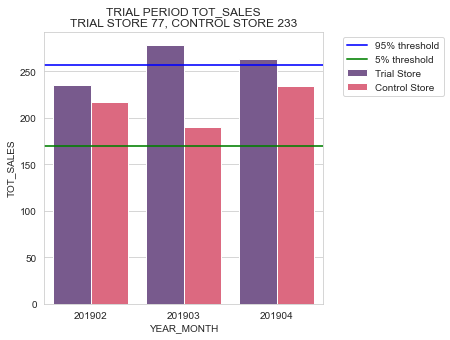

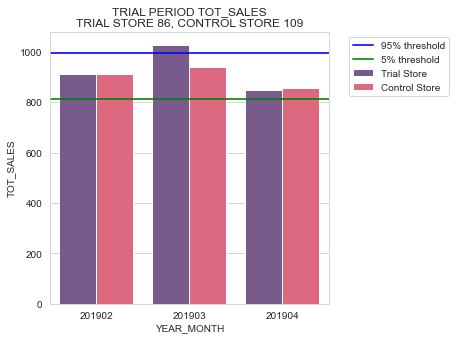

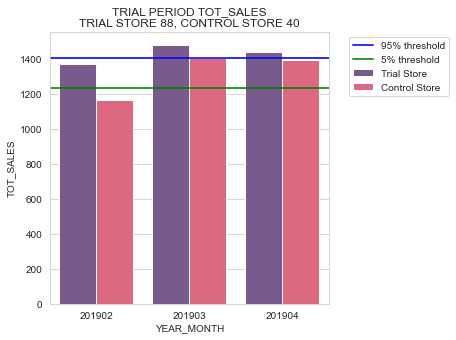

In [32]:
hypothesis_test('TOT_SALES', [233,109,40])

- For both trial and control stores, the p-value between their pre-trial and trial sales are greater than the significance level of 5%. This implies that there isn't a statistically significant difference in the sales of the two period.

- It seems like some of the values of the t-statistic for Trial 77 and 88 are significantly higher than the 95% confidence interval. During the months of March for Trial 77 and February for Trial 88, the store experienced a significant increase in its sales of chips.

-----------------------------------------------
Pre-trial vs Trial sales for CONTROL stores:
-----------------------------------------------
Pre-trial vs trial sales t-test for CONTROL store 233:
Ttest_indResult(statistic=0.8058373793340827, pvalue=0.44377467501190027) 

Pre-trial vs trial sales t-test for CONTROL store 155:
Ttest_indResult(statistic=-2.528388665674838, pvalue=0.05918957324322702) 

Pre-trial vs trial sales t-test for CONTROL store 237:
Ttest_indResult(statistic=-1.600304849007243, pvalue=0.1905389237180138) 

Critical t-statistic for 95% confidence interval: [-4.30265273  4.30265273]

-----------------------------------------------
Pre-trial vs Trial sales for TRIAL stores:
-----------------------------------------------
Pre-trial vs trial sales t-test for TRIAL store 77:
Ttest_indResult(statistic=-1.7822934340934706, pvalue=0.11338269953594604) 

Pre-trial vs trial sales t-test for TRIAL store 86:
Ttest_indResult(statistic=-2.5874064487721182, pvalue=0.06368418316676

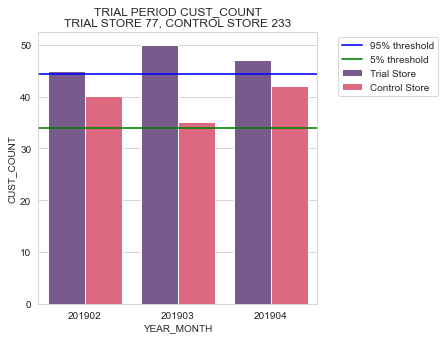

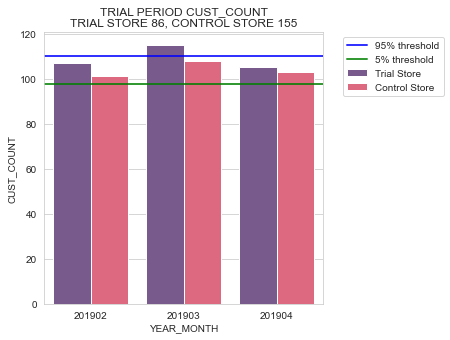

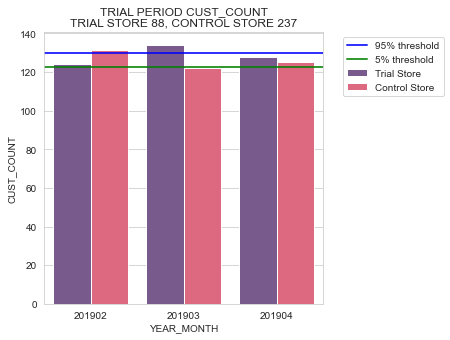

In [33]:
hypothesis_test('CUST_COUNT', [233,155,237])

- Similarly to the sales measure, there is no significant difference statistically for the pre-trial and trial period in both control and trial stores.
- Meanwhile, the t-statistic for Trial 77 and Trial 88 have higher values than the 95% confidence interval for some of their months in the trial period. This implies a significant increase in the number of customers buying from these stores for these months.

To further analyze why only some stores experienced an increase in sales and customers for particular months, we would need additional data and information from our client.